In [1]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# pip install torchsummary

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# 데이터셋 인스턴스 생성
data = pd.read_csv('https://raw.githubusercontent.com/Kim-TaeWook/AI-class/refs/heads/main/week6/diabetes.csv')  # CSV 파일 경로

In [4]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


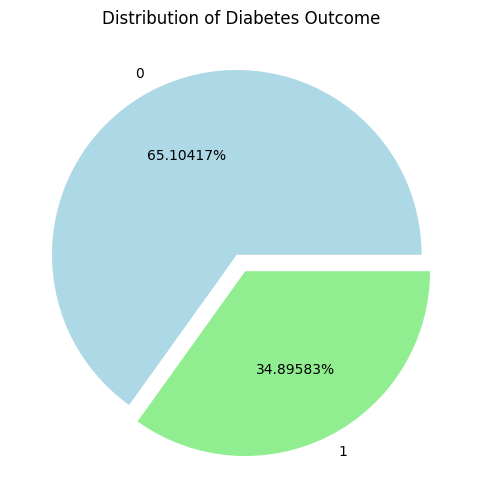

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# Outcome 컬럼으로 접근
data["Outcome"].value_counts().plot(
    kind='pie',
    autopct='%0.05f%%',
    colors=['lightblue', 'lightgreen'],
    explode=(0.05, 0.05)
)

plt.title("Distribution of Diabetes Outcome")
plt.ylabel("")  # 라벨 없애기
plt.show()

In [6]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [7]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [9]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [10]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

## **모델 정의**

In [12]:
# 모델 정의
class DiabetesClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DiabetesClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # 최종 출력: 로짓 값
        return x

input_dim = X_train.shape[1]
model = DiabetesClassifier(input_dim)

print(model)
summary(model, (input_dim,))

DiabetesClassifier(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             144
              ReLU-2                   [-1, 16]               0
            Linear-3                    [-1, 8]             136
              ReLU-4                    [-1, 8]               0
            Linear-5                    [-1, 1]               9
Total params: 289
Trainable params: 289
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## **손실 함수 및 최적화 기법 정의**

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **모델 학습**

In [14]:
# 학습 변수 초기화
train_losses = []
test_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # BCEWithLogitsLoss는 예측값과 정답의 shape가 동일해야 하므로,
        # labels를 (batch_size, 1)로 만들고 float 타입으로 변환합니다.
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Epoch 당 평균 손실 계산
    avg_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(avg_loss)
    
    # 테스트 데이터셋에서 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            # torch.sigmoid를 적용하여 예측 확률을 구한 뒤,
            # 0.5 임계값으로 이진 분류 결과 생성합니다.
            preds = (torch.sigmoid(outputs) >= 0.5).int()
            total += labels.size(0)
            correct += (preds.squeeze(1) == labels).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6912, Accuracy: 62.34%
Epoch 2/20, Loss: 0.6702, Accuracy: 77.27%
Epoch 3/20, Loss: 0.6463, Accuracy: 77.27%
Epoch 4/20, Loss: 0.6222, Accuracy: 77.92%
Epoch 5/20, Loss: 0.5942, Accuracy: 78.57%
Epoch 6/20, Loss: 0.5667, Accuracy: 77.92%
Epoch 7/20, Loss: 0.5414, Accuracy: 78.57%
Epoch 8/20, Loss: 0.5223, Accuracy: 80.52%
Epoch 9/20, Loss: 0.5090, Accuracy: 80.52%
Epoch 10/20, Loss: 0.4993, Accuracy: 80.52%
Epoch 11/20, Loss: 0.4921, Accuracy: 79.87%
Epoch 12/20, Loss: 0.4863, Accuracy: 81.17%
Epoch 13/20, Loss: 0.4822, Accuracy: 81.17%
Epoch 14/20, Loss: 0.4780, Accuracy: 81.17%
Epoch 15/20, Loss: 0.4753, Accuracy: 81.17%
Epoch 16/20, Loss: 0.4728, Accuracy: 80.52%
Epoch 17/20, Loss: 0.4708, Accuracy: 80.52%
Epoch 18/20, Loss: 0.4683, Accuracy: 80.52%
Epoch 19/20, Loss: 0.4675, Accuracy: 79.87%
Epoch 20/20, Loss: 0.4653, Accuracy: 79.87%
Training complete.


## **모델 평가**

In [15]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        # torch.sigmoid 적용 후, 임계값 0.5로 예측 생성 (BCEWithLogitsLoss 사용 시 권장 방법)
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())

# 넘파이 배열로 변환
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions).flatten()  # 혹은 squeeze()로 (N,) 형태로 맞추기

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[94 13]
 [18 29]]
F1 Score: 0.80
Precision: 0.79
Recall: 0.80
Specificity: 0.75


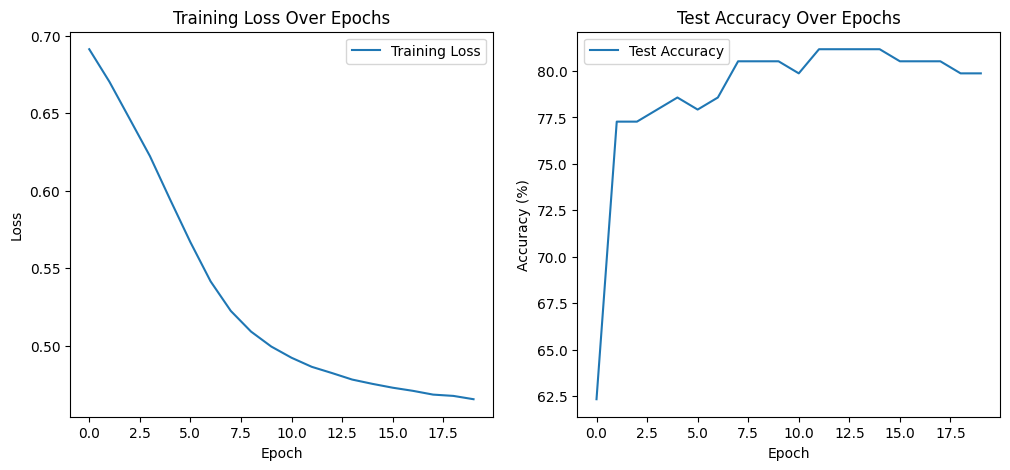

In [16]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

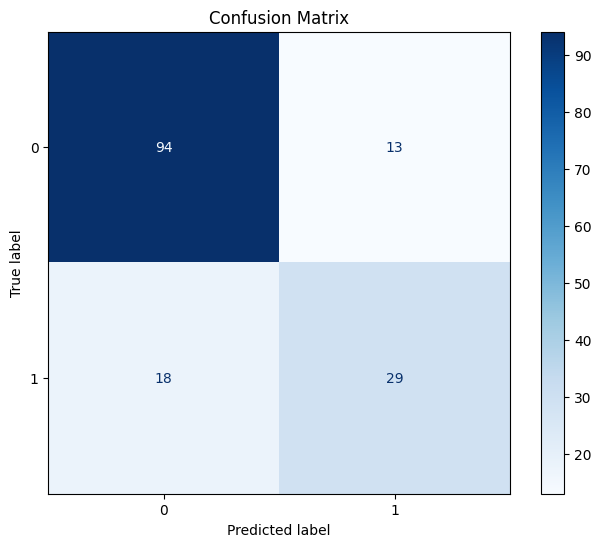

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 혼동행렬 계산
cm = confusion_matrix(all_labels, all_predictions)

# 혼동행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # 파란색 계열로 시각화
plt.title("Confusion Matrix")
plt.show()